# Dealing with Low Confidence Situations

First we analyze a few scenarios where spurious examines or clicks result in inaccurate relevance grades. We then augment the SDBN judgments with a beta prior to better model the amount of confidence we have in the underlying click data.

In [1]:
import sys
sys.path.append("..")
sys.path.append("../ltr")
from aips import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from ltr.sdbn_functions import *
from session_gen import SessionGenerator

# if using a Jupyter notebook, includue:
%matplotlib inline

In [2]:
all_sessions()

,sess_id,query,rank,doc_id,clicked
0,2,ipad,0.0,92636260712,False
1,2,ipad,1.0,635753493559,True
2,2,ipad,2.0,885909393404,False
3,2,ipad,3.0,843404073153,False
4,2,ipad,4.0,885909457595,False
...,...,...,...,...,...
149995,60001,bluray,25.0,23942973416,False
149996,60001,bluray,26.0,25192107191,False
149997,60001,bluray,27.0,27242809710,False
149998,60001,bluray,28.0,600603132872,False


In [3]:
sessions = all_sessions()
products = fetch_products(doc_ids=sessions["doc_id"].unique())
products

,image,upc,name,name_txt_en_split,manufacturer,shortDescription,longDescription,id,_version_,promotion_b
0,"<img height=""100"" src=""../data/retrotech/image...",885909457588,Apple&#xAE; - iPad&#xAE; 2 with Wi-Fi - 16GB -...,Apple&#xAE; - iPad&#xAE; 2 with Wi-Fi - 16GB -...,Apple&#xAE;,"9.7"" widescreen display; 802.11a/b/g/n Wi-Fi; ...",The all-new thinner and lighter design makes i...,508934c3-feb0-46e5-9881-b877cbab2b3c,1791713686203662367,NaN
1,"<img height=""100"" src=""../data/retrotech/image...",36725729872,"Samsung - 15.6"" Laptop - 6GB Memory - 640GB Ha...","Samsung - 15.6"" Laptop - 6GB Memory - 640GB Ha...",Samsung,Windows 7 Home Premium 64-bitTechnical details...,This laptop features a 640GB hard drive for ab...,6604ffb6-4c24-4ad3-961a-26b60daaf201,1791713686223585298,NaN
2,"<img height=""100"" src=""../data/retrotech/image...",814916010240,Amazon - Kindle DX - Graphite,Amazon - Kindle DX - Graphite,Amazon,"9.7"" display with E-Ink technology; supports P...","Store up to 3,500 eBooks on this Kindle digita...",358cdf8f-b22a-4369-adf7-4119ddc90d8c,1791713686410231821,NaN
3,"<img height=""100"" src=""../data/retrotech/image...",885909432257,Apple&#xAE; - MacBook&#xAE; Pro / Intel&#xAE; ...,Apple&#xAE; - MacBook&#xAE; Pro / Intel&#xAE; ...,Apple&#xAE;,ENERGY STAR QualifiedMac OS X 10.6 Snow Leopar...,This laptop features a built-in wireless LAN f...,64ef158f-6f2d-47f7-8c5a-4c591824843f,1791713686413377555,NaN
4,"<img height=""100"" src=""../data/retrotech/image...",883929139446,"Harry Potter and the Deathly Hallows, Part 1 -...","Harry Potter and the Deathly Hallows, Part 1 -...",\N,\N,\N,0b1af3d1-de48-46da-9f1e-1e91b98d66f3,1791713686428057637,NaN
...,...,...,...,...,...,...,...,...,...,...
307,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,df2e2c77-cf3a-4660-9f9a-d568b81f34bc,1791713687126409237,NaN
308,"<img height=""100"" src=""../data/retrotech/image...",97361301747,Star Trek: Fan Collectives - DVD,Star Trek: Fan Collectives - DVD,\N,\N,\N,adb3c120-2f12-43b1-abb3-15f36c23e814,1791713686393454623,NaN
309,"<img height=""100"" src=""../data/retrotech/image...",25192073007,Blues Brothers (Rated) (Unrated) - Widescreen ...,Blues Brothers (Rated) (Unrated) - Widescreen ...,\N,\N,\N,213953c0-9861-428c-95f5-f4b69f5e49aa,1791713686394503174,NaN
310,"<img height=""100"" src=""../data/retrotech/image...",97361301747,Star Trek: Fan Collectives - Fullscreen AC3 Do...,Star Trek: Fan Collectives - Fullscreen AC3 Do...,\N,\N,\N,2cadd56e-6183-4958-bb38-d0954c20746d,1791713686741581825,NaN


## Listing 11.11

Computing relevance judgments for `blue ray` a simulated tail query that represents a misspelling with sparse data.

In [4]:
#%load -s caclulate_examine_probability,calculate_clicked_examined,calculate_grade ../ltr/sdbn_functions.py
def caclulate_examine_probability(sessions):
    last_click_per_session = sessions.groupby(["clicked", "sess_id"])["rank"].max()[True]
    sessions["last_click_rank"] = last_click_per_session
    sessions["examined"] = sessions["rank"] <= sessions["last_click_rank"]
    return sessions

def calculate_clicked_examined(sessions):
    sessions = caclulate_examine_probability(sessions)
    return sessions[sessions["examined"]] \
        .groupby("doc_id")[["clicked", "examined"]].sum()

def calculate_grade(sessions):
    sessions = calculate_clicked_examined(sessions)
    sessions["grade"] = sessions["clicked"] / sessions["examined"]
    return sessions.sort_values("grade", ascending=False)

In [29]:
query = "blue ray"
sessions = get_sessions("blue ray")
sessions = sessions[sessions["sess_id"] < 50050]
sessions = sessions.copy().set_index("sess_id")
calculate_grade(sessions)

,clicked,examined,grade
doc_id,,,
600603132872,1,1,1.000000
827396513927,14,34,0.411765
25192073007,8,20,0.400000
885170033412,6,19,0.315789
600603141003,8,26,0.307692
24543672067,8,27,0.296296
813774010904,2,7,0.285714
883929140855,2,7,0.285714
22265052211,1,4,0.250000


# Figure 11.9

Beta distribution for grade=0.125

a=2.5 b=17.5


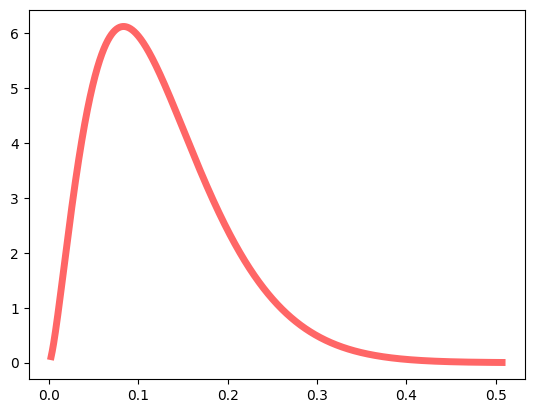

In [6]:
from scipy.stats import beta

prior_grade = 0.125
prior_weight = 20
a = prior_grade * prior_weight; b = (1 - prior_grade) * prior_weight
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 11.10

Adding clicks to the beta distribution

a=3.5 b=17.5


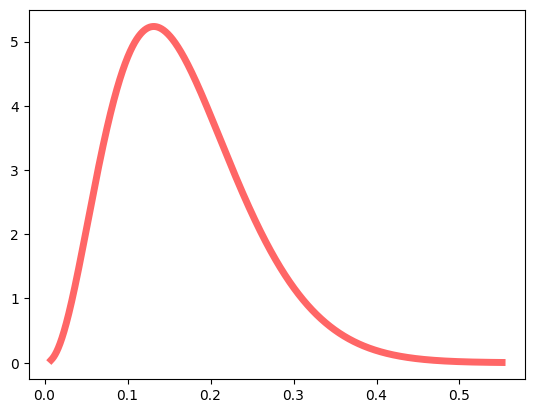

In [7]:
# Fit a beta prior to global_ctr
a += 1
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        "r-", lw=5, alpha=0.6, label="beta pdf")

## Listing 11.12

Starting with a prior beta distribution for each document for "blue ray"

In [31]:
prior_grade = 0.3
prior_weight = 100
sessions = get_sessions("blue ray")
sessions = sessions[sessions["sess_id"] < 50050]
sessions = sessions.copy().set_index("sess_id")
calculate_prior(sessions, prior_grade, prior_weight)

,clicked,examined,grade,prior_a,prior_b
doc_id,,,,,
600603132872,1,1,1.000000,30.0,70.0
827396513927,14,34,0.411765,30.0,70.0
25192073007,8,20,0.400000,30.0,70.0
885170033412,6,19,0.315789,30.0,70.0
600603141003,8,26,0.307692,30.0,70.0
24543672067,8,27,0.296296,30.0,70.0
813774010904,2,7,0.285714,30.0,70.0
883929140855,2,7,0.285714,30.0,70.0
22265052211,1,4,0.250000,30.0,70.0


## Listing 11.13

Here we update the beta posterior to account for the observations in our data. We then compute a new grade, `beta-grade` from the posterior distribution.

In [9]:
#%load -s calculate_sdbn ../ltr/sdbn_functions.py
def calculate_sdbn(sessions, prior_grade=0.3, prior_weight=100):
    sessions = calculate_prior(sessions, prior_grade, prior_weight)
    sessions["posterior_a"] = (sessions["prior_a"] + 
                               sessions["clicked"])
    sessions["posterior_b"] = (sessions["prior_b"] + 
      sessions["examined"] - sessions["clicked"])
    sessions["beta_grade"] = (sessions["posterior_a"] /
      (sessions["posterior_a"] + sessions["posterior_b"]))
    return sessions.sort_values("beta_grade", ascending=False)

In [32]:
sessions = get_sessions("blue ray")
sessions = sessions[sessions["sess_id"] < 50050]
sessions = sessions.set_index("sess_id")
bluray_sdbn = calculate_sdbn(sessions)
bluray_sdbn

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
827396513927,14,34,0.411765,30.0,70.0,44.0,90.0,0.328358
25192073007,8,20,0.400000,30.0,70.0,38.0,82.0,0.316667
600603132872,1,1,1.000000,30.0,70.0,31.0,70.0,0.306931
885170033412,6,19,0.315789,30.0,70.0,36.0,83.0,0.302521
600603141003,8,26,0.307692,30.0,70.0,38.0,88.0,0.301587
24543672067,8,27,0.296296,30.0,70.0,38.0,89.0,0.299213
813774010904,2,7,0.285714,30.0,70.0,32.0,75.0,0.299065
883929140855,2,7,0.285714,30.0,70.0,32.0,75.0,0.299065
22265052211,1,4,0.250000,30.0,70.0,31.0,73.0,0.298077


In [11]:
render_judged(products,
              bluray_sdbn,
              grade_col="beta_grade",
              label=f"SDBN judgments for q={query}")

,beta_grade,image,upc,name,shortDescription
0,0.328358,,8.273965e+11,Panasonic - Refurbished Wi-Fi Ready Blu-ray Disc Player,RefurbishedPlays DVD and Blu-ray Discs; 1080p upconversion; 2-channel analog output104.99
1,0.316667,,2.519207e+10,The Blues Brothers - Widescreen Dubbed Subtitle - Blu-ray Disc,\N
2,0.316667,,2.519207e+10,Blues Brothers (Rated) (Unrated) - Widescreen Dubbed Subtitle - Blu-ray Disc,\N
3,0.306931,NaN,NaN,NaN,NaN
4,0.302521,,8.851700e+11,Panasonic - Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray Discs; HDMI output; analog audio outLearn more about smart products.
5,0.301587,NaN,NaN,NaN,NaN
6,0.299213,,2.454367e+10,Predators - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
7,0.299065,,8.137740e+11,Samsung - Refurbished Wi-Fi Ready Blu-ray Player with HDMI Cable,RefurbishedENERGY STAR QualifiedPlays DVD and Blu-ray Discs; 1080p video output; 2-channel audio outputLearn more about smart products.
8,0.299065,,8.839291e+11,Green Lantern - Blu-ray Disc,\N
9,0.298077,,2.226505e+10,Toshiba - Wi-Fi Ready Blu-ray Player,ENERGY STAR QualifiedPlays DVD and Blu-ray; 1080p HD video output;Learn more about smart products.


In [12]:
products[products["upc"] == 25192073007]

,image,upc,name,name_txt_en_split,manufacturer,shortDescription,longDescription,id,_version_,promotion_b
292,"<img height=""100"" src=""../data/retrotech/image...",25192073007,The Blues Brothers - Widescreen Dubbed Subtitl...,The Blues Brothers - Widescreen Dubbed Subtitl...,\N,\N,\N,1718d3f5-64cc-40b0-a16c-3914b0f61231,1791713686711173140,NaN
309,"<img height=""100"" src=""../data/retrotech/image...",25192073007,Blues Brothers (Rated) (Unrated) - Widescreen ...,Blues Brothers (Rated) (Unrated) - Widescreen ...,\N,\N,\N,213953c0-9861-428c-95f5-f4b69f5e49aa,1791713686394503174,NaN


# Figure 11.10 source code

Rendering beta distribution updated judgments to model our confidence in them

In [17]:
sessions = get_sessions("transformers dark of the moon")
transformers_sdbn = calculate_sdbn(sessions, 0.3, 100)

render_judged(products, 
              transformers_sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={query}")

,beta_grade,image,upc,name,shortDescription
0,0.295238,,4.001929e+11,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
1,0.279279,,4.787584e+10,Transformers: Dark of the Moon - PlayStation 3,Transform into an epic hero or a vehicular villain
2,0.277778,,9.736353e+10,Transformers: Revenge of the Fallen - Widescreen Dubbed Subtitle - DVD,\N
3,0.275229,,9.362496e+10,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
4,0.267241,,9.736356e+10,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
5,0.252101,,3.672524e+10,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",\N
6,0.250000,,2.454375e+10,X-Men: First Class - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
7,0.243056,NaN,NaN,NaN,NaN
8,0.214286,,4.787584e+10,Transformers: Dark of the Moon Autobots - Nintendo DS,Transform into an epic hero or a vehicular villain
9,0.209877,,4.787584e+10,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain


# Figure 11.11 source code

Rendering beta distribution updated judgments to model our confidence in them

In [18]:
sessions = get_sessions("dryer")
dryer_sdbn = calculate_sdbn(sessions, 0.3, 100)

render_judged(products, 
              dryer_sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={query}")

,beta_grade,image,upc,name,shortDescription
0,0.292035,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
1,0.277372,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
2,0.270270,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
3,0.262295,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
4,0.251969,,36725561977,Samsung - 3.5 Cu. Ft. 6-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedSoft dial touch pad controls; 6 cycles; delay-start; child lock; Vibration Reduction Technology
5,0.248175,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
6,0.245690,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
7,0.240000,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package
8,0.233083,,883929085118,A Charlie Brown Christmas - AC3 - Blu-ray Disc,\N
9,0.229008,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"


Up next: [Chapter 12: Overcoming Bias in Learned Relevance Models](../ch12/0.setup.ipynb)